In [2]:
### Imports
import sys
sys.path.insert(0, '/home/augustsemrau/drive/M1semester/02506_AdvancedImageAnalysis/02505miniproject')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init

from PIL import Image

from data_utils import EM_DATA
from U_NET_model import UNet
from model_train import train_model

import skimage.io
import glob 
import os

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)

# U-Net training notebook

## Load Data

In [ ]:
# # Make dataset class.
# class Dataset(torch.utils.data.Dataset):
#     '''  Dataset which loads all images for training or testing'''
#     def __init__(self, train):
#         self._train = train

#         if self._train:
#             image_dir = "Data/train_images"
#             label_dir = "Data/train_labels"
#         else:
#             image_dir = "Data/test_images"

#         self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
#         self.label_paths = sorted(glob.glob(os.path.join(label_dir, "*.png"))) if self._train else None

#         self.images = []
#         self.labels = []
        

#         for idx in range(len(self.image_paths)):
#             self.images.append(torch.tensor(skimage.io.imread(
#                 f'{data_dir}{idx:03d}.png').transpose(2, 0, 1), 
#                 dtype=torch.float32)/255)
#             label_im = skimage.io.imread(
#                 f'{data_dir}{idx:03d}_anno.png')[
#                 margin_size:-margin_size, margin_size:-margin_size]/255
#             self.labels.append(torch.tensor(label_im, dtype=torch.int64))



#     def __getitem__(self, idx):
#         return self.images[idx], self.labels[idx]
    
#     def __len__(self):
#         return len(self.images)

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

## Load the dataset
train_dataset = EM_DATA(train=True, size=256, _transform=transform, data_path="Data")
val_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="Data", validation=True)
test_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="Data")

# train_dataset = Dataset(train=True)
# test_dataset = Dataset(train=False)

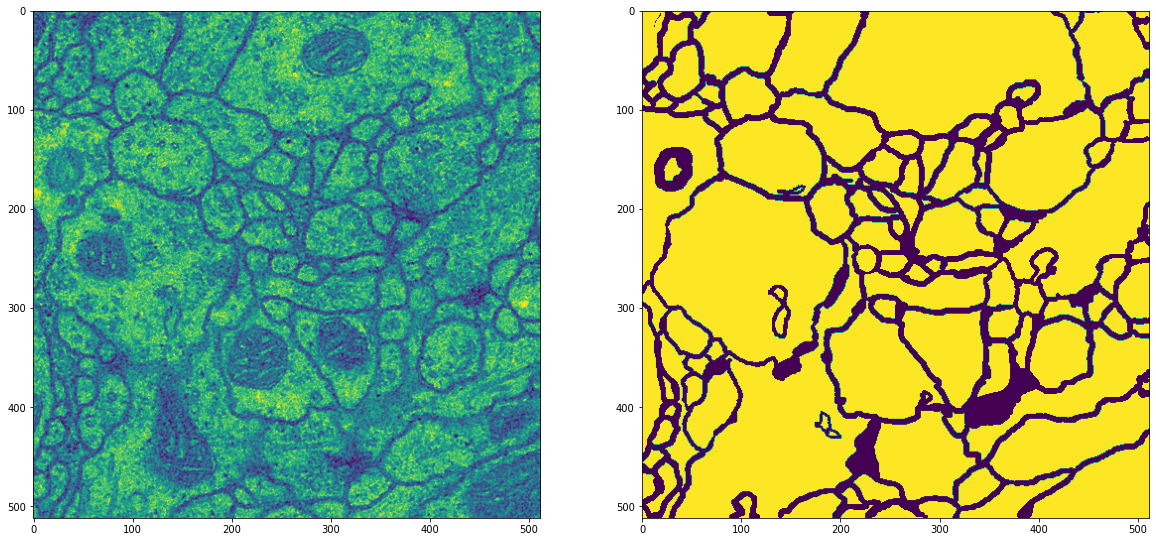

IndexError: list index out of range

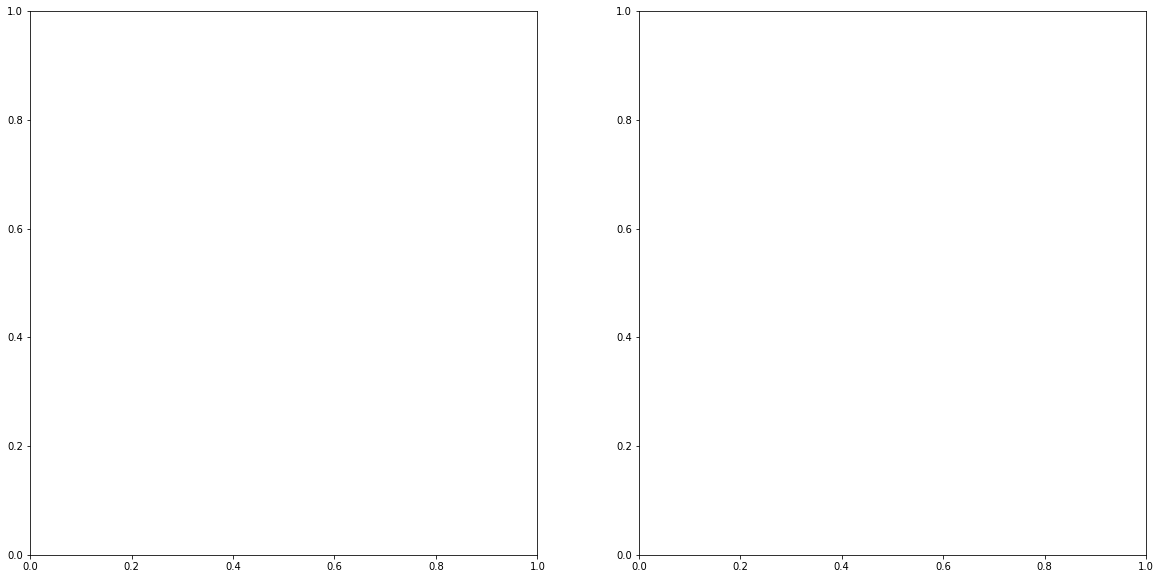

In [14]:
## Show some images from train, val and test sets
fig, ax = plt.subplots(1, 2, figsize=(20,10))

# data_ex = next(iter(train_dataset))
data_ex = train_dataset[21]

ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = val_dataset[4]
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10,10))
data_ex = test_dataset[29]
ax.imshow(data_ex[0].numpy()[0,:,:])
plt.show()


# Initialize and train U-Net
## First setup U-net

In [1]:
## First we init the U-net

# Depth describes levels of unet - default is 5
model = UNet(1, in_channels=1, depth=1, merge_mode='concat')

set_seed(42)

# Test it works
x = Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
out = model(x)
loss = torch.sum(out)
loss.backward()

print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

NameError: name 'UNet' is not defined

## Init optimizer

In [5]:
# learning_rate = 0.8e-3
learning_rate = 3e-4
weight_decay = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training

In [6]:
model, training_loss, validation_loss, global_steps = train_model(model=model, 
                                                                optimizer=optimizer, 
                                                                num_epochs=10, 
                                                                train_dataset=train_dataset, 
                                                                val_dataset=val_dataset, 
                                                                CUDA=False, 
                                                                SAVE_CHECKPOINTS=False)

Epoch 1/10
----------


100%|██████████| 25/25 [01:55<00:00,  4.60s/it]


Traning loss: 3.173986791388161
Validation loss 1.960280418395996
Epoch 2/10
----------


100%|██████████| 25/25 [02:24<00:00,  5.78s/it]


Traning loss: 0.7926138701023449
Validation loss 0.6836801171302795
Epoch 3/10
----------


100%|██████████| 25/25 [02:31<00:00,  6.04s/it]


Traning loss: -1.4389912495423394
Validation loss 0.6836534738540649
Epoch 4/10
----------


100%|██████████| 25/25 [02:33<00:00,  6.15s/it]


Traning loss: -0.34481569647139154
Validation loss 0.6840980052947998
Epoch 5/10
----------


100%|██████████| 25/25 [02:34<00:00,  6.18s/it]


Traning loss: 0.7680972315677675
Validation loss 0.6860953569412231
Epoch 6/10
----------


100%|██████████| 25/25 [02:38<00:00,  6.34s/it]


Traning loss: 0.799254804726081
Validation loss 0.6859093904495239
Epoch 7/10
----------


100%|██████████| 25/25 [02:11<00:00,  5.27s/it]


Traning loss: -0.2648450728255042
Validation loss 0.685555636882782
Epoch 8/10
----------


100%|██████████| 25/25 [02:25<00:00,  5.81s/it]


Traning loss: -0.2718064576908148
Validation loss 0.6856424808502197
Epoch 9/10
----------


100%|██████████| 25/25 [02:18<00:00,  5.53s/it]


Traning loss: 3.0011667220418246
Validation loss 0.6852306723594666
Epoch 10/10
----------


100%|██████████| 25/25 [02:18<00:00,  5.56s/it]

Traning loss: -0.2750918177057823
Validation loss 0.6860911250114441


torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])


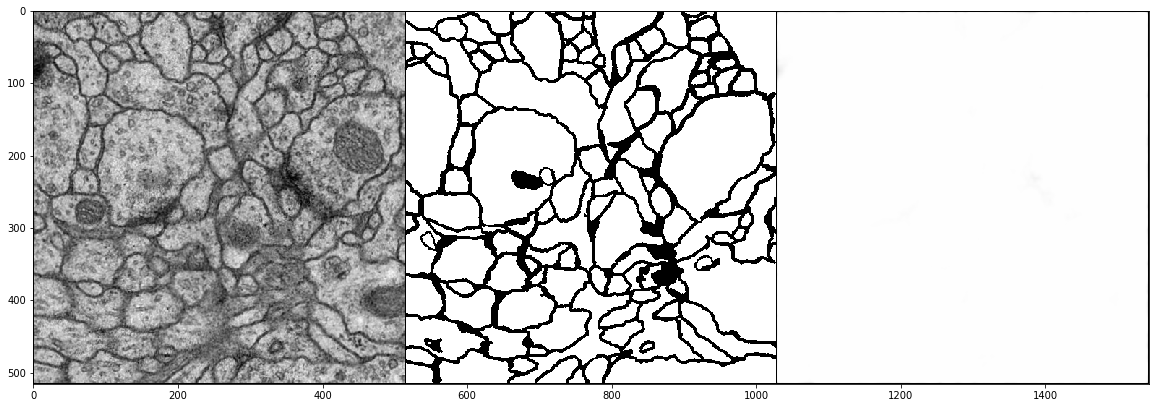

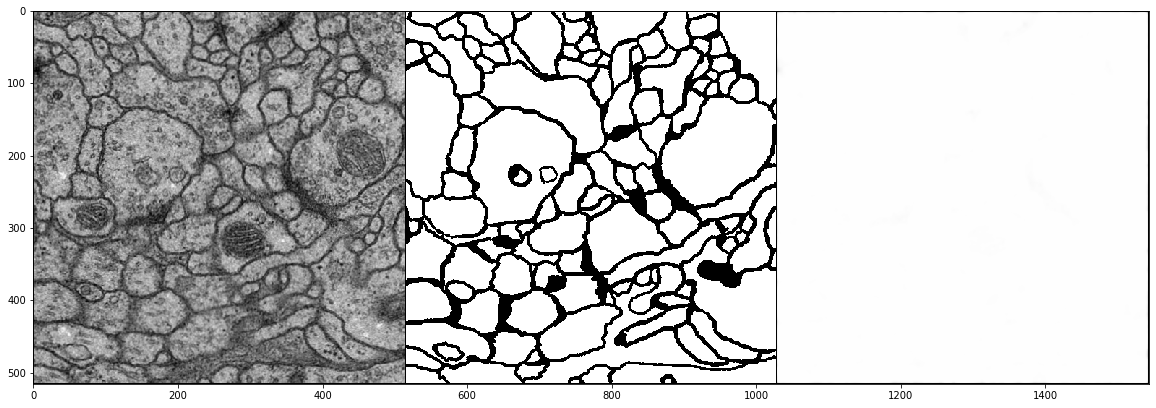

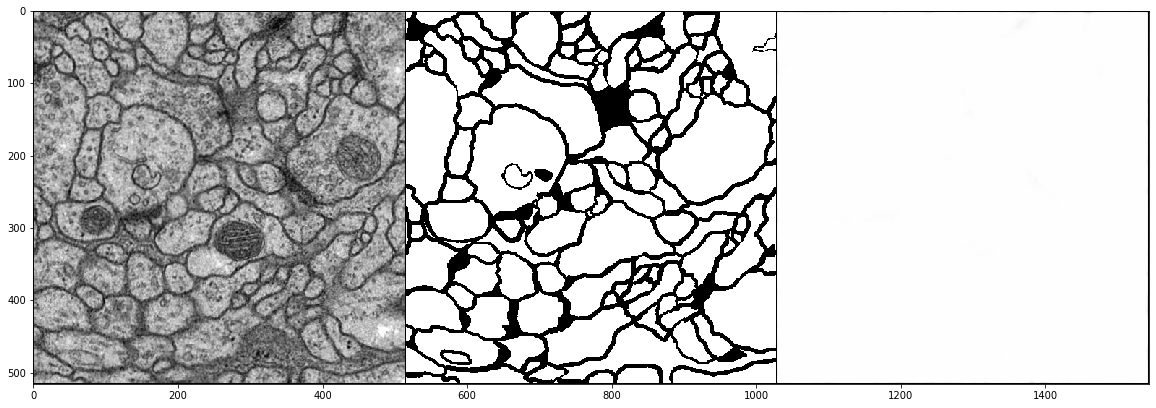

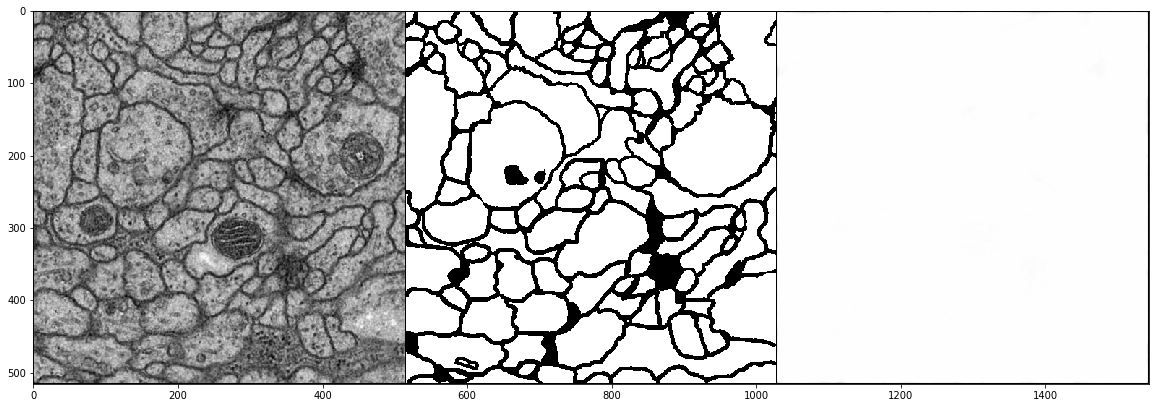

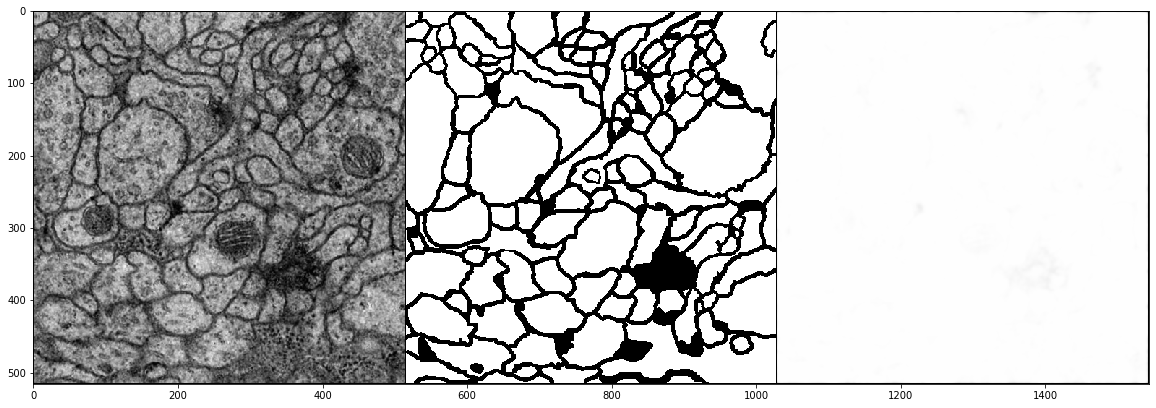

In [10]:
for inputs, targets in val_dataset:
    x = torch.autograd.Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
    inputs=inputs.unsqueeze(0)
    targets=targets.unsqueeze(0)
    y_hat = model(inputs)
    # print(targets.shape)
    # print(y_hat.shape)
    npgrid = torchvision.utils.make_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0))
    print(npgrid.shape)
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

In [8]:
np.transpose(npgrid, (1, 2, 0)).shape

torch.Size([516, 1544, 3])

# Extra

In [9]:
# def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
#     """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

#     grid = torchvision.utils.make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
#     npgrid = grid.cpu().numpy()

#     plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

#     ax = plt.gca()
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)

#     if not (title == ''):
#         plt.title(title)

#     plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)
#     plt.clf()

# # Example usage
# plot_images_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0), 'test.png')